In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
%matplotlib inline
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
n = 8 # n qubits
# m = 2 * n # double qubits for preparing a general target state
m = n + 1 # plus one qubit for preparing a low rank target state
n_layers = 2 * n ** 2 # number of layers in variational circuit
if n == 1:
    n_layers = 0
dev = qml.device('default.qubit', wires=max(m, n))

In [3]:
def variational_circuit(n_layers, weights, wires, **kwargs):
    '''
        Template for a variational circuit.
    '''
    pos = 0
    for i in range(len(wires)):
        qml.RX(weights[pos], wires=wires[i])
        qml.RY(weights[pos+1], wires=wires[i])
        qml.RZ(weights[pos+2], wires=wires[i])
        pos += 3

    for layer in range(n_layers):
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
        
        for i in range(len(wires)):
            qml.RX(weights[pos], wires=wires[i])
            qml.RY(weights[pos+1], wires=wires[i])
            qml.RZ(weights[pos+2], wires=wires[i])
            pos += 3

In [4]:
def get_target(n_layers, params, **kwargs):
    '''
        Prepare target state at the first n qubits.
    '''
    variational_circuit(n_layers, params, np.arange(m))

In [5]:
def variational_qpca(n_layers, variational_params, **kwargs):
    '''
        Perform variational quantum PCA.
    '''
    variational_circuit(n_layers, variational_params, np.arange(n))

In [6]:
@qml.qnode(dev, interface="tf")
def measurement(n_layers, target_params, variational_params, **kwargs):
    '''
        Measure sigma_z for computing PCA loss.
    '''
    get_target(n_layers, target_params)
    variational_qpca(n_layers, variational_params)
    z = []
    for i in range(n):
        z.append(qml.expval(qml.PauliZ(i)))
    return z

def loss_qpca(n_layers, target_params, variational_params, **kwargs):
    '''
        Compute loss for variational quantum PCA, i.e. $Tr(U \rho U^dagger P)$.
    '''
    z = measurement(n_layers, target_params, variational_params)
    return 1 / 2 ** n / (2 ** n - 1) * tf.math.reduce_sum((z + 1) * (2 ** tf.range(n, dtype=tf.double)))

2022-01-20 19:09:36.720252: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-20 19:09:36.720290: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: metis
2022-01-20 19:09:36.720296: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: metis
2022-01-20 19:09:36.720898: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-01-20 19:09:36.720922: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-01-20 19:09:36.720926: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5
2022-01-20 19:09:36.722092: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfor

In [7]:
# initialize parameters
np.random.seed(0)
tf.random.set_seed(0)
n_target_params = (n_layers + 1) * 3 * m
n_var_params = (n_layers + 1) * 3 * n

target_params = np.array([0] * n_target_params) + np.random.normal(scale=np.pi, size=(n_target_params,))

eps = 1e-2
init_var_params = np.array([0] * n_var_params) + np.random.normal(scale=eps, size=(n_var_params,))
# init_var_params = np.loadtxt('./ckpt.csv', delimiter=',')
var_params = tf.Variable(init_var_params)

# SGD faces barren plateau, Adam is better
# lr = 6 for SGD, 0.1 for Adam
# opt = tf.keras.optimizers.SGD(6)
opt = tf.keras.optimizers.Adam(0.1, decay=0.1)
# opt = tf.keras.optimizers.Adadelta(lr=0.1)

In [8]:
# examine the target state
@qml.qnode(dev, interface="tf")
def get_target_state(n_layers, target_params, **kwargs):
    '''
        Get density matrix of the target state.
    '''
    get_target(n_layers, target_params)
    return qml.density_matrix(list(range(n)))

# sigular value decomposition
target_state = get_target_state(n_layers, target_params).numpy()
U, S, V = np.linalg.svd(target_state)
print('eigenvalues: ', S[:10])

# calculate theoretical minimum of loss
loss_minimum = np.sum(S * np.arange(len(S))) / 2 ** n / (2 ** n - 1) * 2
loss_maximum = np.sum(S * np.arange(len(S))[::-1]) / 2 ** n / (2 ** n - 1) * 2
print('loss minimum: ', loss_minimum)
print('loss maximum: ', loss_maximum)

eigenvalues:  [5.25928188e-01 4.74071812e-01 1.58652944e-16 1.33301318e-16
 1.17201016e-16 9.61050892e-17 8.25725193e-17 6.37759923e-17
 5.12069113e-17 5.12069113e-17]
loss minimum:  1.452425894183647e-05
loss maximum:  0.007797975741058282


In [22]:
# train variational quantum PCA
n_step = 50

cost = lambda: loss_qpca(n_layers, target_params, var_params)

# cost_list = []
for step in tqdm(range(n_step)):
    opt.minimize(cost, var_params)
    cost_val = cost().numpy()
    cost_list.append(cost_val)
    if step % 5 == 0:
        tqdm.write("Step {}: cost = {}, relative excess = {}".format(step, cost_val, (cost_val - loss_minimum) / (loss_minimum)))

  0%|          | 0/50 [00:00<?, ?it/s]

Step 0: cost = 1.4524259111743345e-05, relative excess = 1.1698144111514958e-08
Step 5: cost = 1.452425902539783e-05, relative excess = 5.753227006065346e-09
Step 10: cost = 1.4524259019931683e-05, relative excess = 5.376881067732484e-09
Step 15: cost = 1.4524259002887736e-05, relative excess = 4.203399659490321e-09
Step 20: cost = 1.4524258965655872e-05, relative excess = 1.639973629406056e-09
Step 25: cost = 1.4524258952897069e-05, relative excess = 7.615258459097327e-10
Step 30: cost = 1.4524258950528321e-05, relative excess = 5.984367702279219e-10
Step 35: cost = 1.452425894606221e-05, relative excess = 2.9094351529787216e-10
Step 40: cost = 1.4524258944972995e-05, relative excess = 2.15950710650888e-10
Step 45: cost = 1.4524258943734383e-05, relative excess = 1.3067192282891408e-10


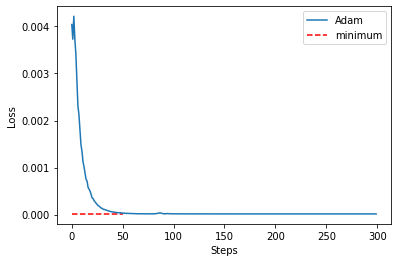

In [23]:
# plot loss
# plt.plot(cost_list_sgd[:400], label='SGD')
plt.plot(cost_list, label='Adam')
# plt.hlines(loss_maximum, 0, n_step, colors='r', linestyles='--', label='maximum')
plt.hlines(loss_minimum, 0, n_step, colors='r', linestyles='--', label='minimum')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
np.savetxt('./ckpt8.csv', var_params.numpy(), delimiter=',')

In [27]:
@qml.qnode(dev, interface="tf")
def get_pca_state(n_layers, target_params, variational_params, **kwargs):
    '''
        Get density matrix of the PCA result.
    '''
    get_target(n_layers, target_params)
    variational_qpca(n_layers, variational_params)
    return qml.density_matrix(list(range(n)))

eigenvalues:  [5.25928188e-01 4.74071812e-01 1.58652944e-16 1.33301318e-16
 1.17201016e-16 9.61050892e-17 8.25725193e-17 6.37759923e-17
 5.12069113e-17 5.12069113e-17]
pca results:  [5.25928188e-01 4.74071812e-01 2.26664937e-13 2.17350088e-14
 8.07256962e-15 6.72380616e-15 5.82285022e-15 5.16438789e-15
 4.61422797e-15 4.35076182e-15]
eigenvalue mse:  6.975751208488965e-28


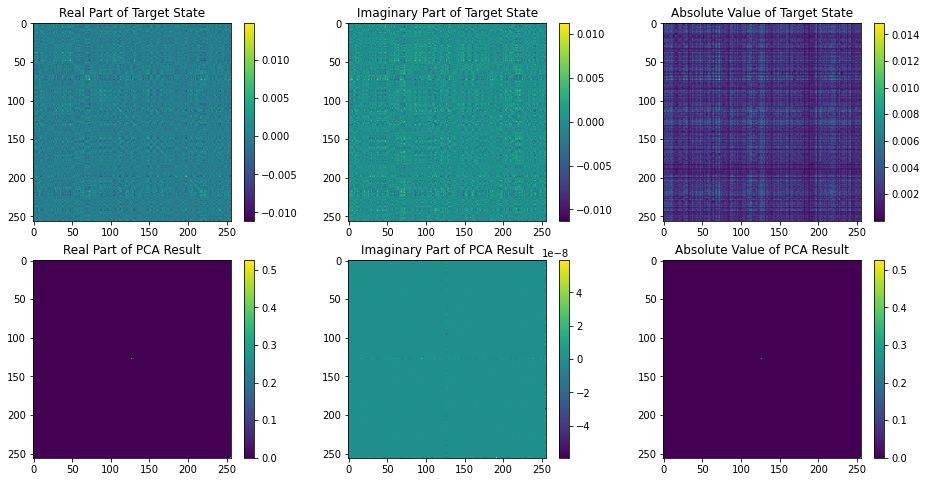

In [28]:
print('eigenvalues: ', S[:10])

# extract and compute eigenvalues from qpca
pca_state = get_pca_state(n_layers, target_params, var_params).numpy()
pca_eigen, order = np.unique(-np.abs(np.diag(pca_state)), return_inverse=True)
pca_eigen = -pca_eigen

print('pca results: ', pca_eigen[:10])
print('eigenvalue mse: ', np.mean((pca_eigen - S) ** 2))

# plot target and pca state
fig, ax = plt.subplots(2, 3, figsize=(16, 8))

im_target_real = ax[0][0].imshow(np.real(target_state))
ax[0][0].set_title('Real Part of Target State')
plt.colorbar(im_target_real, ax=ax[0][0])
im_target_imag = ax[0][1].imshow(np.imag(target_state))
ax[0][1].set_title('Imaginary Part of Target State')
plt.colorbar(im_target_imag, ax=ax[0][1])
im_target_abs = ax[0][2].imshow(np.abs(target_state))
ax[0][2].set_title('Absolute Value of Target State')
plt.colorbar(im_target_abs, ax=ax[0][2])

im_pca_real = ax[1][0].imshow(np.real(pca_state))
ax[1][0].set_title('Real Part of PCA Result')
plt.colorbar(im_pca_real, ax=ax[1][0])
im_pca_imag = ax[1][1].imshow(np.imag(pca_state))
ax[1][1].set_title('Imaginary Part of PCA Result')
plt.colorbar(im_pca_imag, ax=ax[1][1])
im_pca_abs = ax[1][2].imshow(np.abs(pca_state))
ax[1][2].set_title('Absolute Value of PCA Result')
plt.colorbar(im_pca_abs, ax=ax[1][2])

plt.show()

In [29]:
dev_gen = qml.device('default.mixed', wires=n)
@qml.qnode(dev_gen, interface=None)
def generator(pca_eigs, n_layers, variational_params):
    '''
        Generate state via qPCA^dagger.
    '''
    qml.QubitDensityMatrix(np.diag(pca_eigs), wires=list(range(n)))
    qml.adjoint(variational_qpca)(n_layers, variational_params)
    return qml.density_matrix(list(range(n)))

mse of generated state:  7.085133194312242e-18


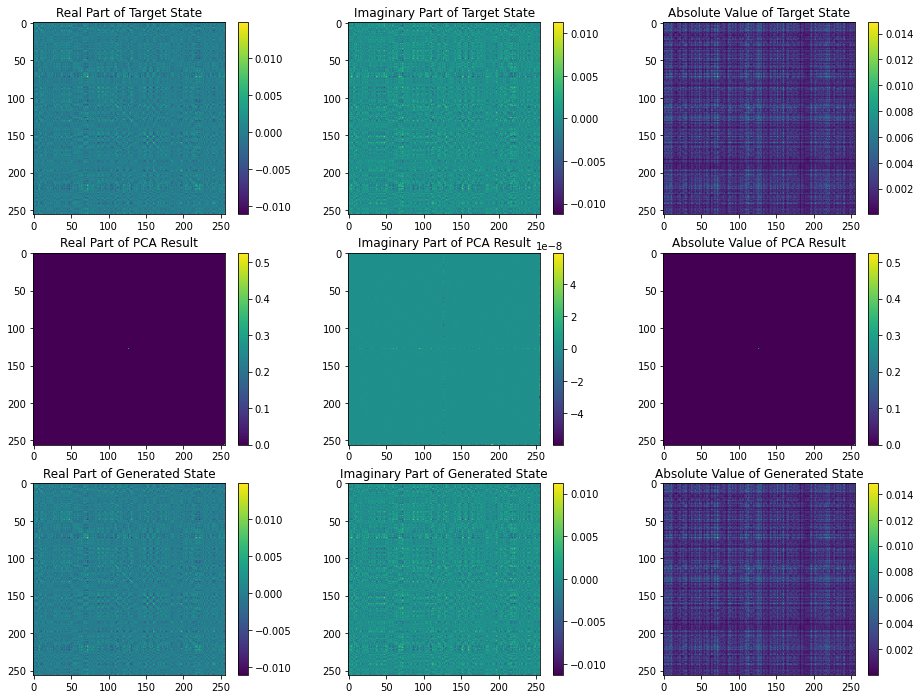

In [30]:
# truncate eigenvalues
n_trunc = 3
trunc_pca_eigs = np.pad(pca_eigen[:n_trunc]/np.sum(pca_eigen[:n_trunc]), (0, 2 ** n - n_trunc), 'constant')[order]
gen_state = generator(trunc_pca_eigs, n_layers, var_params)

# print('real eigs sorted:\n', S)
# print('pca eigs sorted:\n', pca_eigen)
# print('pca eigs:\n', np.diag(pca_state))
# print('trunc pca eigs:\n', trunc_pca_eigs)

print('mse of generated state: ', np.mean(np.abs(gen_state - target_state)**2))

fig, ax = plt.subplots(3, 3, figsize=(16, 12))

im_target_real = ax[0][0].imshow(np.real(target_state))
ax[0][0].set_title('Real Part of Target State')
plt.colorbar(im_target_real, ax=ax[0][0])
im_target_imag = ax[0][1].imshow(np.imag(target_state))
ax[0][1].set_title('Imaginary Part of Target State')
plt.colorbar(im_target_imag, ax=ax[0][1])
im_target_abs = ax[0][2].imshow(np.abs(target_state))
ax[0][2].set_title('Absolute Value of Target State')
plt.colorbar(im_target_abs, ax=ax[0][2])

im_pca_real = ax[1][0].imshow(np.real(pca_state))
ax[1][0].set_title('Real Part of PCA Result')
plt.colorbar(im_pca_real, ax=ax[1][0])
im_pca_imag = ax[1][1].imshow(np.imag(pca_state))
ax[1][1].set_title('Imaginary Part of PCA Result')
plt.colorbar(im_pca_imag, ax=ax[1][1])
im_pca_abs = ax[1][2].imshow(np.abs(pca_state))
ax[1][2].set_title('Absolute Value of PCA Result')
plt.colorbar(im_pca_abs, ax=ax[1][2])

im_gen_real = ax[2][0].imshow(np.real(gen_state))
ax[2][0].set_title('Real Part of Generated State')
plt.colorbar(im_target_real, ax=ax[2][0])
im_gen_imag = ax[2][1].imshow(np.imag(gen_state))
ax[2][1].set_title('Imaginary Part of Generated State')
plt.colorbar(im_target_imag, ax=ax[2][1])
im_gen_abs = ax[2][2].imshow(np.abs(gen_state))
ax[2][2].set_title('Absolute Value of Generated State')
plt.colorbar(im_target_abs, ax=ax[2][2])

plt.show()

In [31]:
# relative entropy
from scipy.linalg import logm
def relative_entropy(rho, sigma):
    return -np.real(np.trace(np.dot(rho, logm(sigma)-logm(rho))))
print('relative entropy: ', relative_entropy(gen_state, target_state))

relative entropy:  2.062147262844871e-11
